In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pymc3
!{sys.executable} -m pip install seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import seaborn as sns
from functions import generate_simulation_data, plot_posteriors

<p class="gap2">
<h1 style="font-weight: bold; color: #12698a">Instrumental Variable Analysis for Estimation of Repetitive Ad Effectiveness<br>
</h1>

<h2 style="color: #50494e">PyMCon 2020</h2>


<p class="gap05">  </p>
<h3 style="color: #12698a">Ruben Mak <br>
Principal Data Scientist and Discovery Cluster Lead at Greenhouse</h3>
<img src="images/PyMC3_banner.svg">
</p>

## Short introduction

<p><img src="images/wpp_greenhouse.png"></p>

## Quickly some terminology
* impression: an ad is loaded once onto a webpage browsed by a user

* conversion: the desired outcome of an advertiser, for example online purchase or visiting a specific webpage on the advertiser's website

* frequency cap: a setting which determines the maximum amount of impressions a user can get of an ad

## Research question
* What is the optimal amount of impressions per user to maximize conversions?

## What does the data say?

<p><img src="images/optimum_plots.png"></p>

## Maybe we should draw a causal graph...

<p><img src="images/causal_graph_1.png"></p>

## Maybe we should draw a causal graph...

<p><img src="images/causal_graph_2.png"></p>

## Instrumental Variable Setup
* The golden standard, A/B test (Random Controlled Trial) doesn't work...

* But we can run a A/B/n test on the frequency cap.

* This is a perfect setting to apply instrumental variables!

## Let's complete our causal graph

<p><img src="images/causal_graph_3.png"></p>

## Research question
* What is the optimal amount of impressions per user to maximize conversions?

* Do we really need instrumental variables, or are we looking for the results of the A/B test instead?

In [3]:
max_cap = 7
max_impr = 7

base_conversion_probability = [0.015, 0.07, 0.07, 0.08, 0.125, 0.08, 0.04]
effects = [0.1, 0.06, 0.04, 0.025, 0.015, 0.01, 0.005]

P_potential_impressions = [0.27, 0.21, 0.19, 0.14, 0.08, 0.06, 0.05]
P_frequency_cap = [1 / max_cap] * max_cap

n_users = 10 ** 6

df = generate_simulation_data(P_potential_impressions,
                            P_frequency_cap,
                            base_conversion_probability,
                            effects,
                            n_users)

df['non_conversions'] = df['users'] - df['conversions']

In [4]:
df

users  conversions  non_conversions
frequency_cap impressions                                      
1             1            142913        22933           119980
2             1             38583         4434            34149
              2            104329        24665            79664
3             1             38656         4485            34171
              2             30062         6877            23185
              3             74453        20899            53554
4             1             38306         4458            33848
              2             29836         6737            23099
              3             27205         7313            19892
              4             47341        14565            32776
5             1             38660         4384            34276
              2             29928         6789            23139
              3             27305         7364            19941
              4             19894         6079            13815
              5             27225         8882            18343
6             1             38323         4372            33951
              2             29947         6955            22992
              3             26935         7198            19737
              4             20091         6069            14022
              5             11394         4165             7229
              6             15640         4897            10743
7             1             38849         4407            34442
              2             29961         6894            23067
              3             26830         7297            19533
              4             20167         6186            13981
              5             11485         4234             7251
              6              8496         2809             5687
              7              7186         2203             4983

In [5]:
df_impressions = df.groupby(['impressions']).sum()
df_impressions

,users,conversions,non_conversions
impressions,,,
1,374290,49473,324817
2,254063,58917,195146
3,182728,50071,132657
4,107493,32899,74594
5,50104,17281,32823
6,24136,7706,16430
7,7186,2203,4983


In [6]:
df_frequency_cap = df.groupby(['frequency_cap']).sum()
df_frequency_cap

,users,conversions,non_conversions
frequency_cap,,,
1,142913,22933,119980
2,142912,29099,113813
3,143171,32261,110910
4,142688,33073,109615
5,143012,33498,109514
6,142330,33656,108674
7,142974,34030,108944


In [7]:
n_samples = 10 ** 4

P_Y_given_X = [stats.beta.rvs(
    df_impressions['conversions'][i],
    df_impressions['non_conversions'][i],
    size = n_samples) for i in df_impressions.index]

P_Y_given_Z = [stats.beta.rvs(
    df_frequency_cap['conversions'][i],
    df_frequency_cap['non_conversions'][i],
    size = n_samples) for i in df_frequency_cap.index]

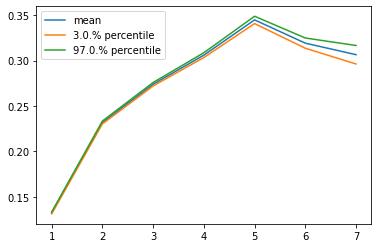

In [8]:
plot_posteriors(df_impressions.index, P_Y_given_X)

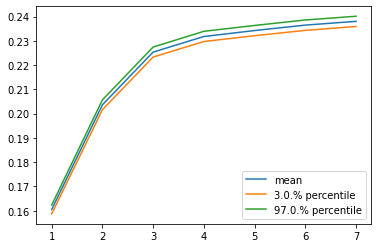

In [9]:
plot_posteriors(df_frequency_cap.index, P_Y_given_Z)

## Two stage approach

<h1><center>Stage 1: $x = c_1 + z \theta + \varepsilon_1$</center></h1>

<h1><center>Stage 2: $y = c_2 + \hat{x} \beta + \varepsilon_2$</center></h1>

<h1><center>$\hat{x} = \hat{c_1} + z \hat{\theta}$</center></h1>

<h2><center>$\hat{x} \sim Beta(a, b)$</center></h2>

In [44]:
a_xhat = np.zeros((max_cap, max_cap))
for i in range(max_cap):
    for j in range(max_cap):
        a_xhat[i, j] = np.sum(df.loc[i+1].users[df.loc[i+1].index >= j+1])
n_xhat = np.array([df_frequency_cap.users] * max_cap).T
b_xhat = n_xhat - a_xhat
xhat = a_xhat / n_xhat

In [11]:
column_names = ['impression {}'.format(i+1) for i in range(max_impr)]
index_names = ['cap {}'.format(i+1) for i in range(max_impr)]
pd.DataFrame(xhat, columns = column_names, index = index_names)

,impression 1,impression 2,impression 3,impression 4,impression 5,impression 6,impression 7
cap 1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cap 2,1.0,0.730023,0.000000,0.000000,0.000000,0.000000,0.000000
cap 3,1.0,0.730001,0.520028,0.000000,0.000000,0.000000,0.000000
cap 4,1.0,0.731540,0.522441,0.331780,0.000000,0.000000,0.000000
cap 5,1.0,0.729673,0.520404,0.329476,0.190369,0.000000,0.000000
cap 6,1.0,0.730745,0.520340,0.331097,0.189939,0.109885,0.000000
cap 7,1.0,0.728279,0.518724,0.331067,0.190014,0.109684,0.050261


<h1><center>
    Model 1<br>
    <br>
    $Y \sim $Binomial$(U, P(Y|Z))$<br>
    $P(Y|Z) = $logistic$(\beta \hat{x})$<br>
    $\beta \sim $Normal$(0, 10)$<br>
</center></h1>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


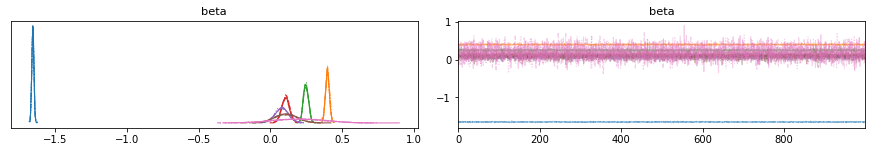

In [12]:
with pm.Model() as model_1:
    beta = pm.Normal('beta', mu=0, sigma=10, shape=max_cap)
    p = sum(beta[i] * xhat[:, i] for i in range(max_cap))
    p = pm.math.invlogit(p)
    conversion = pm.Binomial('conversion', 
                             df_frequency_cap.users, 
                             p, 
                             observed=df_frequency_cap.conversions)
    model_1 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_1)

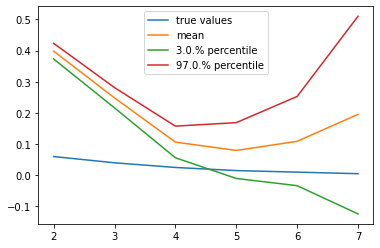

In [13]:
beta_plot_1 = np.array(model_1['beta']).T
plot_posteriors(df_frequency_cap.index[1:], beta_plot_1[1:], effects[1:])

<h1><center>
    Model 2: Switch to Normal distribution<br>
    <br>
    $Y \sim $Normal$(p U, \bar{\sigma})$<br>
    $\bar{\sigma} = \sqrt{U\bar{p}(1-\bar{p})}$<br>
    $p = \beta \hat{x}$<br>
    $\beta \sim $Normal$(0, 0.1)$<br>
</center></h1>

In [ ]:
with pm.Model() as model_2:
    beta = pm.Normal('beta', mu=0, sigma=0.1, shape=max_cap)
    p = sum(beta[i] * xhat[:, i] for i in range(max_cap))
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_2 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_2)

0.1573034702740343 0.24191194184485362


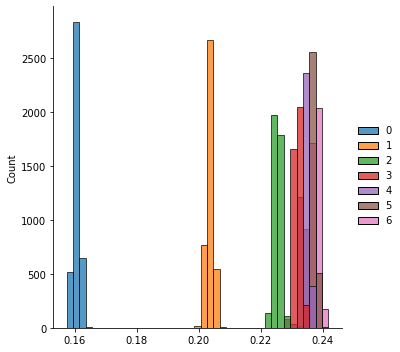

In [15]:
# are we ok with our normal distribution assumption?
print(np.min(model_2['p']), np.max(model_2['p']))
sns.displot(model_2['p'])

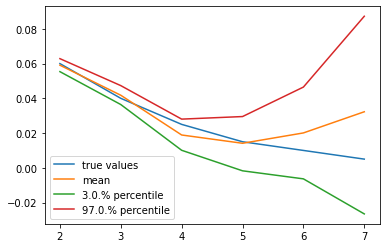

In [16]:
beta_plot_2 = np.array(model_2['beta']).T
plot_posteriors(df_frequency_cap.index[1:], beta_plot_2[1:], effects[1:])

## Making Assumptions
* Core of modelling: variance / bias trade-off

* Let's see what happens when we assume $\beta_i \geq 0$

<h1><center>
    Model 3: Assume $\beta_i \geq 0$<br>
    <br>
    $Y \sim $Normal$(p U, \bar{\sigma})$<br>
    $\bar{\sigma} = \sqrt{U\bar{p}(1-\bar{p})}$<br>
    $p = c + \beta \hat{x}$<br>
    $c \sim $Normal$(0, 0.5)$<br>
    $\beta \sim $HalfNormal$(0.1)$<br>
</center></h1>

In [ ]:
with pm.Model() as model_3:
    c = pm.Normal('c', mu = 0, sigma = 0.5)
    beta = pm.HalfNormal('beta', sigma=0.1, shape=max_cap)
    p = c + sum(beta[i] * xhat[:, i] for i in range(1, max_cap))
    # Note: we skip beta_0 because we now have c
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_3 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_3)

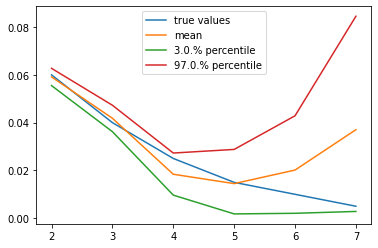

In [18]:
beta_plot_3 = np.array(model_3['beta']).T
plot_posteriors(df_frequency_cap.index[1:], beta_plot_3[1:], effects[1:])

## Making Assumptions
* Core of modelling: variance / bias trade-off

* Let's make some assumptions on a parametric form for $\beta_i$

<h1><center>
    Model 4<br>
    <br>
    $Y \sim $Normal$(p U, \bar{\sigma})$<br>
    $\bar{\sigma} = \sqrt{U\bar{p}(1-\bar{p})}$<br>
    $p = c + \beta \hat{x}$<br>
    $c \sim $Normal$(0, 0.5)$<br>
    $\beta_i = e^{\alpha_0 + i\alpha_1}$<br>
    $\alpha_0 \sim $Normal$(-2, 2)$<br>
    $\alpha_1 \sim $Normal$(0, 2)$<br>
</center></h1>

In [ ]:
with pm.Model() as model_4:
    c = pm.Normal('c', mu = 0, sigma = 0.5)
    alpha0 = pm.Normal('alpha0', mu=-2, sigma=2)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=2)
    beta = pm.Deterministic('beta', 
                        np.exp(alpha0 + alpha1 * np.array(range(max_cap))))
    p = c + sum(beta[i] * xhat[:, i] for i in range(max_cap))
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_4 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_4)

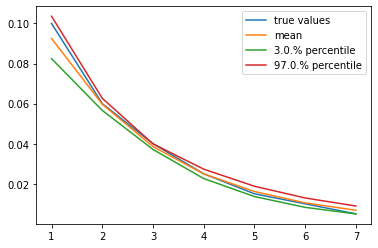

In [29]:
# Note: we also have an estimate for the first impressions now
beta_plot_4 = np.array(model_4['beta']).T
plot_posteriors(df_frequency_cap.index, beta_plot_4, effects)

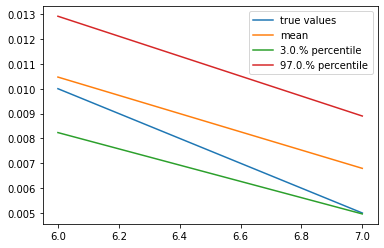

In [30]:
plot_posteriors(df_frequency_cap.index[5:7], beta_plot_4[5:7], effects[5:7])

<h1><center>
    Model 5: Include Hierarchy<br>
    <br>
    $Y \sim $Normal$(p U, \bar{\sigma})$<br>
    $\bar{\sigma} = \sqrt{U\bar{p}(1-\bar{p})}$<br>
    $p = c + \beta \hat{x}$<br>
    $c \sim $Normal$(0, 0.5)$<br>
    $\beta_i = e^{\alpha_0^i + i\alpha_1}$<br>
    $\alpha_0 \sim $Normal$(-2, 2)$<br>
    $\sigma^{\alpha} \sim $HalfNormal$(0.5)$<br>
    $\alpha_0^i \sim $Normal$(\alpha_0, \sigma^{\alpha})$<br>
    $\alpha_1 \sim $Normal$(0, 2)$<br>
</center></h1>

In [ ]:
with pm.Model() as model_5:
    alpha0_prior = pm.Normal('alpha0_prior', mu=-2, sigma=2)
    alpha0_sigma = pm.HalfNormal('alpha0_sigma', sigma = 0.5)
    alpha0 = pm.Normal('alpha0', 
                       mu=alpha0_prior, sigma=alpha0_sigma, shape=max_cap)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=2)
    beta = pm.Deterministic('beta', 
                            np.exp(alpha0 + alpha1 * np.array(range(max_cap))))
    p = sum(beta[i] * xhat[:, i] for i in range(max_cap))
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_5 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_5)

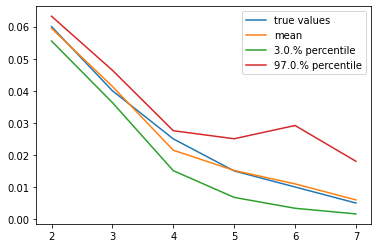

In [32]:
beta_plot_5 = np.array(model_5['beta']).T
plot_posteriors(df_frequency_cap.index[1:], beta_plot_5[1:], effects[1:])

## However...
* Our posteriors are too optimistic

* We assume $\hat{x}$ to be deterministic, while in fact $\hat{x} \sim Beta(a, b)$

* Estimation error (variance) within our estimates is in fact larger because of estimation error in the first stage

## What didn't work for me
* Implement theano random stream to do random draws from $\hat{x} \sim Beta(a, b)$ during MCMC estimation

* Estimation of $\hat{x}$ in the same model (i.e. estimate both stages at once)

In [ ]:
# Trying to estimate both stages at once like this, doesn't seem to work
with pm.Model() as model_6:
    xhat_pm = pm.Beta('xhat_pm', 1, 1, shape=(max_impr, max_cap))
    xbar = pm.Binomial('xbar', n_xhat, xhat_pm, observed=a_xhat)
    c = pm.Normal('c', mu = 0, sigma = 0.5)
    alpha0 = pm.Normal('alpha0', mu=-2, sigma=2)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=2)
    beta = pm.Deterministic('beta', 
                            np.exp(alpha0 + alpha1 * np.array(range(max_cap))))
    p = c + sum(beta[i] * xhat_pm[:, i] for i in range(max_cap))
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_6 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_6)

## My 'bootstrapping' approach
* We sample from $\hat{x} \sim Beta(a, b)$ and estimate our model N times using the sampled $\tilde{x}$

In [ ]:
N_runs = 100

for r in range(N_runs):
    xtilde = stats.beta.rvs(a_xhat+1, b_xhat+1)
    print('This is run {} out of {}'.format(r+1, N_runs))
    try:
        with pm.Model() as model_7:
            c = pm.Normal('c', mu = 0, sigma = 0.5)
            alpha0 = pm.Normal('alpha0', mu=-2, sigma=2)
            alpha1 = pm.Normal('alpha1', mu=0, sigma=2)
            beta = pm.Deterministic('beta', 
                            np.exp(alpha0 + alpha1 * np.array(range(max_cap))))
            p = c + sum(beta[i] * xtilde[:, i] for i in range(max_cap))
            p = pm.Deterministic('p', p)
            p_sample_average = df_frequency_cap.conversions \
                                    / df_frequency_cap.users
            p_sigma = np.sqrt(df_frequency_cap.users * 
                              p_sample_average * (1 - p_sample_average))
            conversion = pm.Normal('conversion', 
                                     mu = p * df_frequency_cap.users,
                                     sigma = p_sigma, 
                                     observed=df_frequency_cap.conversions)
            model_7 = pm.sample(100, tune=1000, chains=4, cores=4)
    except:
        continue
    if r == 0:
        beta_plot_7 = np.array(model_7['beta'])
    else:
        beta_plot_7 = np.vstack((beta_plot_7, np.array(model_7['beta'])))

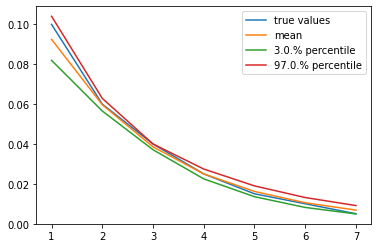

In [73]:
plot_posteriors(df_frequency_cap.index, beta_plot_7.T, effects)

In [ ]:
N_runs = 100

for r in range(N_runs):
    xtilde = stats.beta.rvs(a_xhat+1, b_xhat+1)
    print(xtilde)
    print('This is run {} out of {}'.format(r+1, N_runs))
    try:
        with pm.Model() as model_8:
            beta = pm.Normal('beta', mu=0, sigma=0.1, shape=max_cap)
            p = sum(beta[i] * xtilde[:, i] for i in range(max_cap))
            p = pm.Deterministic('p', p)
            p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
            p_sigma = np.sqrt(df_frequency_cap.users * 
                              p_sample_average * (1 - p_sample_average))
            conversion = pm.Normal('conversion', 
                                     mu = p * df_frequency_cap.users,
                                     sigma = p_sigma, 
                                     observed=df_frequency_cap.conversions)
            model_8 = pm.sample(100, tune=1000, chains=4, cores=4)
    except:
        continue
    if r == 0:
        beta_plot_8 = np.array(model_8['beta'])
    else:
        beta_plot_8 = np.vstack((beta_plot_8, np.array(model_8['beta'])))

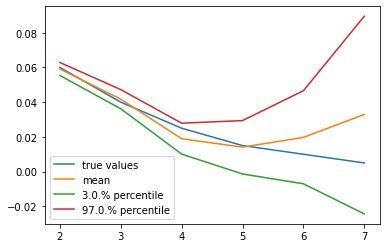

In [76]:
plot_posteriors(df_frequency_cap.index[1:], beta_plot_8.T[1:], effects[1:])

In [52]:
# Note: alternative for calculating xtilde
xtilde = np.zeros(xhat.shape)
for i in range(max_cap):
    for j in range(max_impr):
        if a_xhat[i, j] > 0 and b_xhat[i, j] > 0:
            xtilde[i, j] = stats.beta.rvs(a_xhat[i, j], b_xhat[i, j])
        elif a_xhat[i, j] > 0 and b_xhat[i, j] == 0:
            xtilde[i, j] = 1
xtilde

[[9.99989239e-01 5.53745723e-06 1.26413857e-06 8.12348488e-06
  1.57861288e-05 8.40078345e-06 8.74189865e-07]
 [9.99995845e-01 7.30569744e-01 2.40323071e-07 6.39845302e-06
  3.35318894e-05 5.25249209e-06 9.27762848e-07]
 [9.99998571e-01 7.29210223e-01 5.19608754e-01 1.16902853e-06
  1.32101755e-05 7.69419914e-06 1.43113671e-05]
 [9.99996738e-01 7.30103592e-01 5.22421057e-01 3.31684677e-01
  1.14617726e-06 1.08229473e-06 4.35014803e-06]
 [9.99986363e-01 7.29966987e-01 5.21015879e-01 3.27813692e-01
  1.88631751e-01 4.61066473e-06 2.28441285e-05]
 [9.99998059e-01 7.30527040e-01 5.18576004e-01 3.30466132e-01
  1.87654669e-01 1.09575892e-01 2.39853964e-07]
 [9.99991455e-01 7.29488357e-01 5.18483121e-01 3.29733954e-01
  1.90625963e-01 1.08230361e-01 5.00011063e-02]]


array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [1.        , 0.7322136 , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [1.        , 0.7306144 , 0.52062985, 0.        , 0.        ,
        0.        , 0.        ],
       [1.        , 0.73221867, 0.52400197, 0.33202902, 0.        ,
        0.        , 0.        ],
       [1.        , 0.72983344, 0.52087233, 0.32670812, 0.19107708,
        0.        , 0.        ],
       [1.        , 0.72953164, 0.52379811, 0.33114555, 0.18967569,
        0.11046421, 0.        ],
       [1.        , 0.72669286, 0.5198746 , 0.3314446 , 0.18971119,
        0.108038  , 0.0492439 ]])

## Why does it seem to have little effect?
* The variance in $\hat{x}$ is small in comparison to the variance in $P(Y|Z)$

* How would you approach incorporating the variance of the first stage estimation?

## Recap: when to use instrumental variables
* You need to have unbiased estimates of causal effects

* You can't A/B test the treatment of interest

* You can run an A/B test something that influences the treatment of interest, but not the outcome directly

* You're sure you don't just need the results of the A/B tests

## Conclusion
* Instrumental variables can be applied to quite specific setups

* You can get unbiased estimates of causal effects for something you can't A/B test

* In this talk, I showed you how to estimate using PyMC3 following the two-stage approach

* When you run into problems with variance, you can start modelling by making parametric assumptions

* Hierachical modelling can be used to soften assumptions

* I showed my 'bootstrapping' method for taking the first stage estimation error into account

## Questions?

In [ ]:
!jupyter nbconvert instrumental_variable_frequency_cap.ipynb --to slides --post serve

[NbConvertApp] Converting notebook instrumental_variable_frequency_cap.ipynb to slides
[NbConvertApp] Writing 673276 bytes to instrumental_variable_frequency_cap.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/instrumental_variable_frequency_cap.slides.html
Use Control-C to stop this server
